In [ ]:
# for quantify the substrate

In [2]:
%cd ~/REVIVAL2
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

/disk2/fli/REVIVAL2


In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from REVIVAL.util import get_file_name

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, DataStructs

from REVIVAL.global_param import LIB_INFO_DICT

/disk2/fli/miniconda3/envs/SSMuLA_2/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [4]:
common_cols = [
    "lib",
    "hd",
    "ev_score",
    "esm_score",
    "esmif_score_apo-score",
    "coves_score_apo_clean-output-100_processed",
    "Triad_score_score-frompdb-cleanup",
    "ligandmpnn_score",
    "flowsite_score",
    "complexscore",
    "vina_apo-score-substrate_cofactor-docked",
    "var_vol",
]
common_heme_col = common_cols + [
    "chain_iptm_BA_avg_score_seperate_chai",
    "chain_pae_min_CA_avg_score_seperate_af3",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
    "num_hydrogen_bond_avg_af3-score_seperate",
    # "num_interactions_avg_af3-score_seperate"
]


common_col_dict = {
    "lib": "Library",
    "hd": "Hamming distance",
    "ev_score": "EVmutation",
    "esm_score": "ESM2",
    "esmif_score_apo-score": "ESM-IF",
    "coves_score_apo_clean-output-100_processed": "CoVES",
    "Triad_score_score-frompdb-cleanup": "Triad",
    "ligandmpnn_score": "LigandMPNN",
    "flowsite_score": "FlowSite",
    "complexscore": "GALigandock",
    "vina_apo-score-substrate_cofactor-docked": "Vina",
    "var_vol": "Active site volume",
}
common_heme_col_dict = {
    **common_col_dict,
    "chain_iptm_BA_avg_score_seperate_chai": "Chai",
    "chain_pae_min_CA_avg_score_seperate_af3": "AF3",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
    "num_hydrogen_bond_avg_af3-score_seperate": "Hydrogen bonds",
    # "num_interactions_avg_af3-score_seperate": "PLIP",
}

trpb_cols = common_cols + [
    "chain_iptm_AB_avg_score_joint_chai",
    "chain_pae_min_BA_avg_score_joint_af3",
    "2:GLU-NH_2_avg_af3-struct_joint",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
    "num_hydrogen_bond_avg_af3-score_joint",
    # "num_interactions_avg_af3-score_joint"
]

trpb_col_dict = {
    **common_col_dict,
    "chain_iptm_AB_avg_score_joint_chai": "Chai",
    "chain_pae_min_BA_avg_score_joint_af3": "AF3",
    "2:GLU-NH_2_avg_af3-struct_joint": "Bond distance",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
    "num_hydrogen_bond_avg_af3-score_joint": "Hydrogen bonds",
    # "num_interactions_avg_af3-score_joint": "PLIP",
}

parlq_cols = common_heme_col + ["0:C-C_1_avg_af3-struct_seperate"]

parlq_col_dict = {
    **common_heme_col_dict,
    "0:C-C_1_avg_af3-struct_seperate": "Bond distance",
}

cb_col = common_heme_col + ["0:C-B_avg_af3-struct_seperate"]

cb_col_dict = {**common_heme_col_dict, "0:C-B_avg_af3-struct_seperate": "Bond distance"}

csi_col = common_heme_col + ["0:C-Si_avg_af3-struct_seperate"]
csi_col_dict = {
    **common_heme_col_dict,
    "0:C-Si_avg_af3-struct_seperate": "Bond distance",
}

In [5]:
col_order = [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai",
            "AF3",
            "GALigandock",
            "Vina",
            "Bond distance",
            "Hydrogen bonds",
            # "PLIP",
            "Hydrophobicity",
            "Active site volume",
        ]

In [6]:
lib_order = [
    "PfTrpB-7iodo",
    "PfTrpB-7methyl",
    "PfTrpB-7bromo",
    "PfTrpB-5iodo",
    "PfTrpB-5bromo",
    "PfTrpB-5chloro",
    "PfTrpB-4bromo",
    "PfTrpB-6chloro",
    "PfTrpB-5cyano",
    "PfTrpB-4cyano",
    "PfTrpB-56chloro",
    "Rma-CB",
    "Rma-CSi",
    "ParLQ",
    "ParLQ-b",
    "ParLQ-c",
    "ParLQ-d",
    "ParLQ-e",
    "ParLQ-f",
    "ParLQ-g",
    "ParLQ-h",
    "ParLQ-i",
]
# substrate
# 7iodo       0.605263
# 7methyl     0.605263
# 7bromo      0.605263
# 5iodo       0.600000
# 5bromo      0.600000
# 5chloro     0.600000
# 4bromo      0.550000
# 6chloro     0.536585
# 5cyano      0.489796
# 4cyano      0.489362
# 56chloro    0.333333
# Name: Atom Pair, dtype: float64


In [7]:
df_rho = pd.read_csv("/disk2/fli/REVIVAL2/zs/metrics/fit_rho.csv")
df_rho

,lib,selectivity,n_mut,hd,ev_score,esm_score,flowsite_score,flowsite_std,ligandmpnn_score,var_vol,...,0:C-Si_agg_af3-struct_joint,0:C-Si_avg_af3-struct_joint,0:C-Si_std_af3-struct_joint,0:C-Si_agg_af3-struct_seperate,0:C-Si_avg_af3-struct_seperate,0:C-Si_std_af3-struct_seperate,0:C-Si_avg_chai-struct_joint,0:C-Si_std_chai-struct_joint,0:C-Si_avg_chai-struct_seperate,0:C-Si_std_chai-struct_seperate
0,ParLQ-a,0.961007,0.231575,-0.231575,0.064764,-0.016563,0.149739,0.767178,0.102997,0.000721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ParLQ-b,0.716367,0.214107,-0.214107,0.069212,-0.350559,-0.088342,0.002325,-0.364423,0.189141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ParLQ-c,0.922010,0.160432,-0.160432,0.109442,-0.260408,-0.125243,0.351489,-0.272798,0.119710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ParLQ-d,0.923523,0.131004,-0.131004,0.071439,-0.212725,0.159946,0.293343,0.013028,0.216661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ParLQ-e,0.885885,0.094295,-0.094295,0.003063,-0.126422,0.206172,0.045374,0.080714,0.115888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ParLQ-f,0.801194,0.099254,-0.099254,0.187746,-0.133461,0.054642,0.344720,-0.119939,0.153514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ParLQ-g,0.663896,0.064206,-0.064206,0.127933,-0.095302,0.129352,0.138254,0.049180,0.242398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ParLQ-h,0.914111,0.231071,-0.231071,0.052008,-0.302914,-0.164055,0.057270,-0.273802,0.245456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ParLQ-i,0.720592,0.267521,-0.267521,-0.070933,-0.326358,-0.052970,0.223252,-0.226835,0.258078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PfTrpB-4bromo,NaN,-0.371285,0.371285,0.474594,0.478416,0.415240,0.212191,0.522690,0.196373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
cb_df = df_rho[df_rho["lib"] == "Rma-CB"][cb_col].rename(columns=cb_col_dict).reset_index(drop=True).copy()
csi_df = df_rho[df_rho["lib"] == "Rma-CSi"][csi_col].rename(columns=csi_col_dict).reset_index(drop=True).copy()
parlq_df = df_rho[df_rho["lib"].isin(lib_order[-9:])][parlq_cols].rename(columns=parlq_col_dict).reset_index(drop=True).copy()
parlq_df.loc[parlq_df["Library"]=="ParLQ", "Library"] = "ParLQ-a"
new2nature_df = pd.concat([cb_df, csi_df, parlq_df], axis=0).reset_index(drop=True).sort_values(by="Library")
new2nature_df

,Library,Hamming distance,EVmutation,ESM2,ESM-IF,CoVES,Triad,LigandMPNN,FlowSite,GALigandock,Vina,Active site volume,Chai,AF3,Hydrophobicity,Hydrogen bonds,Bond distance
2,ParLQ-b,-0.214107,0.069212,-0.350559,-0.138534,-0.425412,-0.229385,-0.364423,-0.088342,-0.159309,0.045758,0.189141,0.116930,0.193525,-0.098895,-0.045918,-0.051744
3,ParLQ-c,-0.160432,0.109442,-0.260408,-0.040022,-0.311929,-0.201736,-0.272798,-0.125243,-0.039210,0.123865,0.119710,0.104380,0.256742,-0.073357,0.168407,-0.278818
4,ParLQ-d,-0.131004,0.071439,-0.212725,-0.055805,-0.100844,-0.205686,0.013028,0.159946,-0.021261,0.044362,0.216661,0.047746,0.365860,-0.068977,0.156444,-0.164341
5,ParLQ-e,-0.094295,0.003063,-0.126422,0.088398,-0.013673,-0.012988,0.080714,0.206172,-0.017248,0.006217,0.115888,0.001640,0.335681,-0.047357,0.046059,-0.083095
6,ParLQ-f,-0.099254,0.187746,-0.133461,0.069135,-0.139975,-0.088788,-0.119939,0.054642,-0.018681,0.057543,0.153514,-0.033126,0.278623,-0.038439,0.095870,-0.010543
7,ParLQ-g,-0.064206,0.127933,-0.095302,0.066109,0.009333,0.019541,0.049180,0.129352,-0.032633,-0.064561,0.242398,0.040373,0.289401,-0.025912,0.025332,-0.083485
8,ParLQ-h,-0.231071,0.052008,-0.302914,-0.084647,-0.228062,-0.067718,-0.273802,-0.164055,-0.207215,0.122815,0.245456,0.116499,0.275381,-0.053305,-0.072234,-0.012024
9,ParLQ-i,-0.267521,-0.070933,-0.326358,-0.094187,-0.130690,-0.226039,-0.226835,-0.052970,-0.163784,0.016541,0.258078,0.225131,0.283123,-0.107756,0.040276,-0.020529
0,Rma-CB,0.061590,0.241046,0.214661,0.130128,0.038847,0.108142,0.260575,0.118630,0.094297,0.071539,-0.153503,0.173947,0.362757,0.099902,0.174850,0.037481
1,Rma-CSi,0.039558,0.117369,0.162468,0.063926,0.025011,0.082114,0.123856,-0.008253,0.151583,0.090462,-0.082343,0.155185,0.397210,-0.048594,0.104020,-0.176156


In [9]:
arbitratey_energy = {
    "ParLQ-a": 11,
    "ParLQ-b": 14.5,
    "ParLQ-c": 12.5,
    "ParLQ-d": 13.5,
    "ParLQ-e": 16,
    "ParLQ-f": 17,
    "ParLQ-g": 18,
    "ParLQ-h": 20,
    "ParLQ-i": 21,
    "Rma-CSi": 19,
    "Rma-CB": 13,
}
arbitratey_energy = {k: v for k, v in sorted(arbitratey_energy.items(), key=lambda item: item[1])}

In [10]:
# Convert the 'substrate' column to a Categorical type with the custom order
# trpb_df['substrate'] = pd.Categorical(trpb_df['substrate'], categories=atom_pair_vals.keys(), ordered=True)

# # Sort the DataFrame based on the 'substrate' column
# trpb_df = trpb_df.sort_values('substrate')



#  Melt the dataframe to long format for seaborn boxplot and stripplot
new2nature_melted = pd.melt(
    new2nature_df[col_order],
    id_vars="Library",
    var_name="ZS predictor",
    value_name="Spearman's ρ with fitness",
)
# trpbdf_melted["ZS predictor"] = pd.Categorical(trpbdf_melted['ZS predictor'], categories=col_order, ordered=True)
# trpbdf_melted = trpbdf_melted.sort_values(['substrate','ZS predictor'])
new2nature_melted

,Library,ZS predictor,Spearman's ρ with fitness
0,ParLQ-b,Hamming distance,-0.214107
1,ParLQ-c,Hamming distance,-0.160432
2,ParLQ-d,Hamming distance,-0.131004
3,ParLQ-e,Hamming distance,-0.094295
4,ParLQ-f,Hamming distance,-0.099254
...,...,...,...
155,ParLQ-g,Active site volume,0.242398
156,ParLQ-h,Active site volume,0.245456
157,ParLQ-i,Active site volume,0.258078
158,Rma-CB,Active site volume,-0.153503


Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
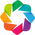

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from REVIVAL.vis_param import FZL_PALETTES

%matplotlib inline

/tmp/ipykernel_440509/2386062460.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Greens_r")
/tmp/ipykernel_440509/2386062460.py:25: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


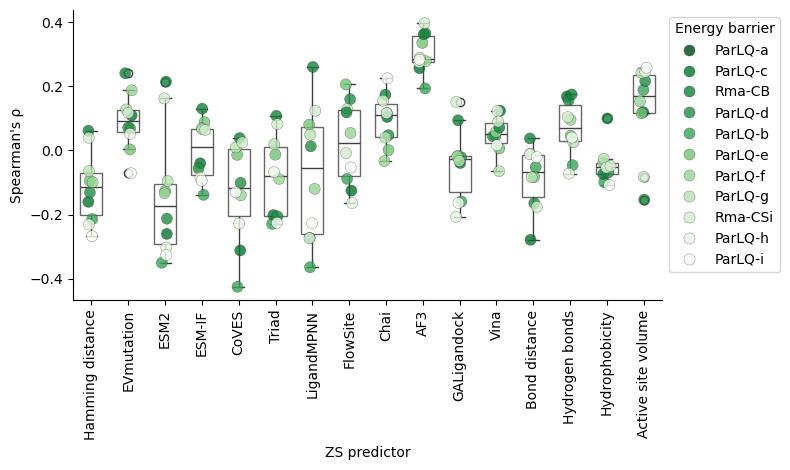

In [12]:
heatmap_values = arbitratey_energy
new2nature_melted["energy"] = new2nature_melted["Library"].map(heatmap_values)

# Normalize heatmap values for colormap
norm = Normalize(vmin=min(heatmap_values.values()), vmax=max(heatmap_values.values()))
cmap = get_cmap("Greens_r")

# Map substrates to colors
substrate_colors = {
    substrate: cmap(norm(value)) for substrate, value in heatmap_values.items()
}

# Create the boxplot and stripplot
plt.figure(figsize=(8, 4.8))
ax = sns.boxplot(
    x="ZS predictor",
    y="Spearman's ρ with fitness",
    data=new2nature_melted,
    boxprops={
        "facecolor": "None",
        "edgecolor": FZL_PALETTES["gray"],
    },
    width=0.6
)
sns.stripplot(
    x="ZS predictor",
    y="Spearman's ρ with fitness",
    hue="Library",
    data=new2nature_melted,
    palette=substrate_colors,  # glasbey_category10[:11],
    jitter=True,
    # dodge=True,
    size=8,
    marker="o",
    edgecolor="gray",
    linewidth=0.2,
    alpha=0.8,
    ax=ax,
    hue_order=heatmap_values.keys(),
)

# Hide the top and right spine
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# rotate x-axis labels
plt.xticks(rotation=90)

# Adjust legend
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Energy barrier")

# Adjust the legend order explicitly (use the custom order if necessary)
# handles, labels = ax.get_legend_handles_labels()
# sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: list(heatmap_values.keys()).index(x[0]))
# sorted_labels, sorted_handles = zip(*sorted_handles_labels)
# ax.legend(sorted_handles, sorted_labels, title="Substrate")
# rename the y-axis
plt.ylabel("Spearman's ρ")
plt.savefig("figs/new2nature.svg", format="svg", dpi=300, bbox_inches="tight")
# Show the plot
plt.tight_layout()
plt.show()


In [13]:
# merge with energy
new2nature_df = new2nature_df.merge(
    pd.DataFrame(arbitratey_energy.items(), columns=["Library", "energy"]),
    on="Library",
    how="left",
)
new2nature_df

,Library,Hamming distance,EVmutation,ESM2,ESM-IF,CoVES,Triad,LigandMPNN,FlowSite,GALigandock,Vina,Active site volume,Chai,AF3,Hydrophobicity,Hydrogen bonds,Bond distance,energy
0,ParLQ-b,-0.214107,0.069212,-0.350559,-0.138534,-0.425412,-0.229385,-0.364423,-0.088342,-0.159309,0.045758,0.189141,0.116930,0.193525,-0.098895,-0.045918,-0.051744,14.5
1,ParLQ-c,-0.160432,0.109442,-0.260408,-0.040022,-0.311929,-0.201736,-0.272798,-0.125243,-0.039210,0.123865,0.119710,0.104380,0.256742,-0.073357,0.168407,-0.278818,12.5
2,ParLQ-d,-0.131004,0.071439,-0.212725,-0.055805,-0.100844,-0.205686,0.013028,0.159946,-0.021261,0.044362,0.216661,0.047746,0.365860,-0.068977,0.156444,-0.164341,13.5
3,ParLQ-e,-0.094295,0.003063,-0.126422,0.088398,-0.013673,-0.012988,0.080714,0.206172,-0.017248,0.006217,0.115888,0.001640,0.335681,-0.047357,0.046059,-0.083095,16.0
4,ParLQ-f,-0.099254,0.187746,-0.133461,0.069135,-0.139975,-0.088788,-0.119939,0.054642,-0.018681,0.057543,0.153514,-0.033126,0.278623,-0.038439,0.095870,-0.010543,17.0
5,ParLQ-g,-0.064206,0.127933,-0.095302,0.066109,0.009333,0.019541,0.049180,0.129352,-0.032633,-0.064561,0.242398,0.040373,0.289401,-0.025912,0.025332,-0.083485,18.0
6,ParLQ-h,-0.231071,0.052008,-0.302914,-0.084647,-0.228062,-0.067718,-0.273802,-0.164055,-0.207215,0.122815,0.245456,0.116499,0.275381,-0.053305,-0.072234,-0.012024,20.0
7,ParLQ-i,-0.267521,-0.070933,-0.326358,-0.094187,-0.130690,-0.226039,-0.226835,-0.052970,-0.163784,0.016541,0.258078,0.225131,0.283123,-0.107756,0.040276,-0.020529,21.0
8,Rma-CB,0.061590,0.241046,0.214661,0.130128,0.038847,0.108142,0.260575,0.118630,0.094297,0.071539,-0.153503,0.173947,0.362757,0.099902,0.174850,0.037481,13.0
9,Rma-CSi,0.039558,0.117369,0.162468,0.063926,0.025011,0.082114,0.123856,-0.008253,0.151583,0.090462,-0.082343,0.155185,0.397210,-0.048594,0.104020,-0.176156,19.0


In [14]:
corr_df_list = []
num_cols = new2nature_df.columns[1:-1]
for num_col in num_cols:
    rho, pval = spearmanr(new2nature_df[num_col], new2nature_df["energy"])
    corr_df_list.append({
        "num_col": num_col,
        "rho": rho,
        "pval": pval,
    })

corr_df = pd.DataFrame(corr_df_list)
corr_df

,num_col,rho,pval
0,Hamming distance,-0.296970,0.404702
1,EVmutation,-0.393939,0.259998
2,ESM2,-0.163636,0.651477
3,ESM-IF,-0.296970,0.404702
4,CoVES,0.066667,0.854813
5,Triad,0.018182,0.960240
6,LigandMPNN,-0.103030,0.776998
7,FlowSite,-0.200000,0.579584
8,GALigandock,-0.296970,0.404702
9,Vina,-0.224242,0.533401
